We will define a periodic function, $f(x)$, with period $s="110"$ where $f(x)=f(y)$ iff $x=y \oplus s$ as follows.

|  x  | f(x) |
| --- | ---- |
| 000 | 000  |
| 001 | 001  | 
| 010 | 100  | 
| 011 | 101  | 
| 100 | 100  | 
| 101 | 101  |
| 110 | 000  | 
| 111 | 001  | 

Note: Whenever converting kets to strings or vice versa, we must reverse the order because qiskit orders the values as $x_0x_1x_2$ whereas the string is ordered $x_2x_1x_0$.

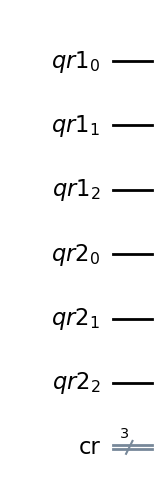

In [1]:
# state vectors of the quantum circuit at each barrier
# reverses are used to put in big endian format
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import StatevectorSimulator

# secret string
s = '110'

# initialize registers
n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')

simulator = StatevectorSimulator()

# beginning
qc = QuantumCircuit(qr1, qr2, cr)
qc = qc.reverse_bits()
job = simulator.run(qc)
statevector = job.result().get_statevector()
qc = qc.reverse_bits()
qc.draw('mpl')

In [2]:
statevector.draw('latex')

<IPython.core.display.Latex object>

The left three qubits are from the first register and the right three qubits are from the second register. In Simon's algorithm, we initialize them all to 0, which is why we start with $|000000\rangle$.

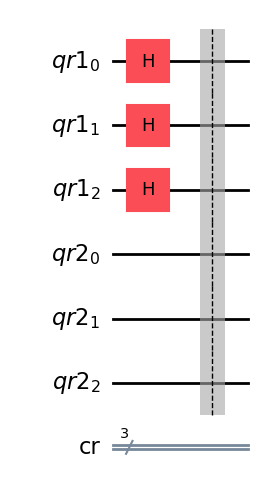

In [3]:
# first round of Hadamards
qc.h(qr1)
qc.barrier()
qc = qc.reverse_bits()
job = simulator.run(qc)
statevector = job.result().get_statevector()
qc = qc.reverse_bits()
qc.draw('mpl')

In [4]:
statevector.draw('latex')

<IPython.core.display.Latex object>

The Hadamard transform on the first register should give us something of the form $\frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}|x\rangle\otimes|000\rangle$. 
In our case, it should be $\frac{1}{\sqrt{2^3}}\sum_{x\in\{0,1\}^3}|x\rangle\otimes|000\rangle$, which we see above.

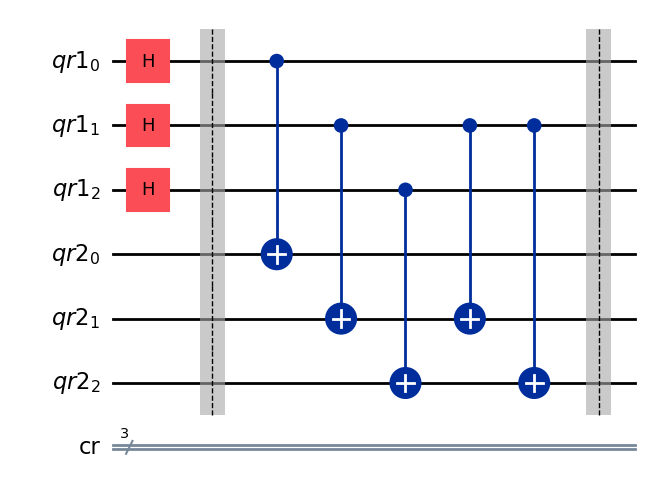

In [5]:
# oracle
qc.cx(qr1, qr2)
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
qc.barrier()
qc = qc.reverse_bits()
job = simulator.run(qc)
statevector = job.result().get_statevector()
qc = qc.reverse_bits()
qc.draw('mpl')

In [6]:
statevector.draw('latex')

<IPython.core.display.Latex object>

After the oracle, we should get something of the form $\frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}|x\rangle\otimes|fx)\rangle$. If doing the calculation by hand, we have to reverse $|x\rangle$ to get its string equivalent when plugging into the function's truth table because of how the oracle is constructed in the algorithm. Doing this, we get the result above. 

By constructing the oracle like this, we create a superposition of states in the first register that are useful for finding the period ($s$) of the function.

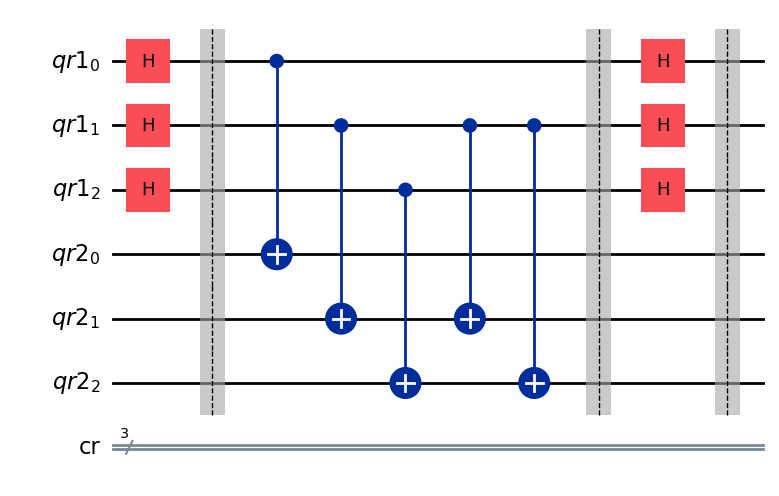

In [7]:
# second round of Hadamards
qc.h(qr1)
qc.barrier()
qc = qc.reverse_bits()
job = simulator.run(qc)
statevector = job.result().get_statevector()
qc = qc.reverse_bits()
qc.draw('mpl')

In [8]:
statevector.draw('latex')

<IPython.core.display.Latex object>

After the second Hadamard transformation on the first register, we should get a result of the form $\frac{1}{2^n}\sum_{y\in\{0,1\}^n}\sum_{x\in\{0,1\}^n}(-1)^{x \cdot y}|y\rangle\otimes|f(x)\rangle$.

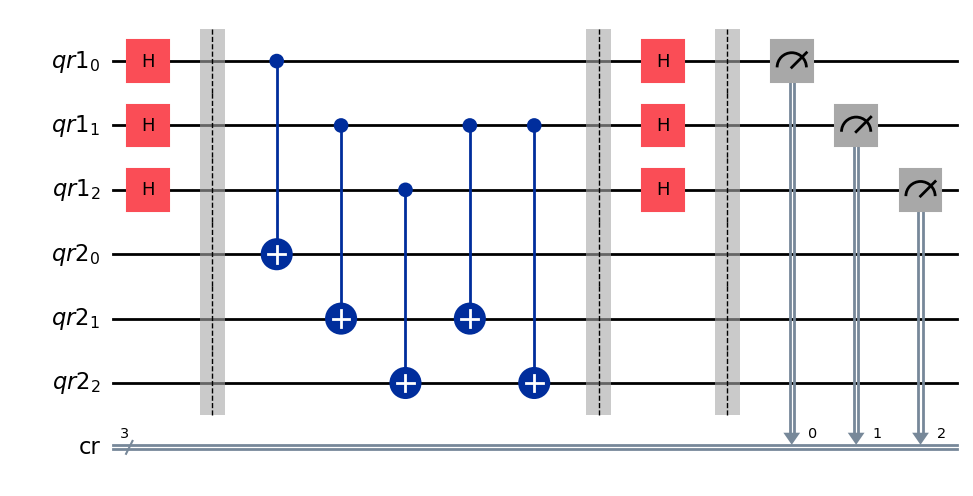

In [9]:
# measurement
qc.measure(qr1, cr)
qc = qc.reverse_bits()
job = simulator.run(qc)
statevector = job.result().get_statevector()
qc = qc.reverse_bits()
qc.draw('mpl')

In [10]:
statevector.draw('latex')

<IPython.core.display.Latex object>

As we can see, we find a single measurement for the first register. It is unnecessary to measure the second register for Simon's algorithm; all we care about is the value of the first register. However, we use the second register to prove a property that makes Simon's Algorithm work. 

$x \cdot s=0$

Why?

Before measuring, we have $\frac{1}{2^n}\sum_{y\in\{0,1\}^n}\sum_{x\in\{0,1\}^n}(-1)^{x \cdot y}|y\rangle\otimes|f(x)\rangle$.

The second qubit register represents a certain $f(x)$. Due to the premise of Simon's algorithm, we know that two strings, $x_1$ and $x_2$, produce this output, $w$ ($w=f(x_1)=f(x_2)$). This means $x$ can be both $x_1$ and $x_2$. 

Looking at this instance, we can rewrite the previous expression to get $\frac{1}{\sqrt{2^n}}\sum_{y\in\{0,1\}^n}((-1)^{x_1 \cdot y}+(-1)^{x_2 \cdot y})|y\rangle\otimes|w\rangle$. When we measure a result, $|y\rangle$, we know that the amplitudes must not cancel. $(-1)^{x_1 \cdot y}+(-1)^{x_2 \cdot y} \neq 0$.


$-1$ to any power is either $-1$ or $1$. This means $(-1)^{x_1 \cdot y}+(-1)^{x_2 \cdot y}$ can either be $0$ or $\pm2$.

The expression cannot equal $0$, so we have two possibilities:

$(-1)^{x_1 \cdot y}+(-1)^{x_2 \cdot y} = -2$, so both $(-1)^{x_1 \cdot y}$ and $(-1)^{x_2 \cdot y}$ evaluate to $-1$.

$(-1)^{x_1 \cdot y}+(-1)^{x_2 \cdot y} = 2$, so both $(-1)^{x_1 \cdot y}$ and $(-1)^{x_2 \cdot y}$ evaluate to $1$.

Either way, $(-1)^{x_1 \cdot y}=(-1)^{x_2 \cdot y}$.

Therefore, $x_1 \cdot y=x_2 \cdot y$ (mod $2$).

From the problem definition, we know that if $f(x)=f(y)$, then $x=y \oplus s$. 

Since $f(x_1)=f(x_2)$, $x_1=x_2 \oplus s$.

Applying the dot product with $y$, we get $x_1 \cdot y = (x_2 \oplus s) \cdot y$ (mod $2$).

Distributing on the right side, we get $x_1 \cdot y = ((x_2 \cdot y) \oplus (s \cdot y))$ (mod $2$).

Substituting $(-1)^{x_1 \cdot y}=(-1)^{x_2 \cdot y}$, we get $x_1 \cdot y = ((x_1 \cdot y) \oplus (s \cdot y))$ (mod $2$).

Therefore, $s \cdot y = 0$ (mod $2$) because any $n$-bit bitstring XOR'ed with $0^n$ results in the same original bitstring.

Now, we can rerun the quantum circuit until we get $n-1$ linearly independent outputs in order to set up and solve a system of equations, solving for each bit of $s$.